# Modelos para pronóstico de cuenta corriente (de series de tiempo y de ciencia de datos)

Debido a que los indicadores que componen la cuenta corriente se encuentran en constante revisión, las cuales pueden ser considerables, es necesario guardar las diferentes versiones con las que se corren los modelos para pronosticarla.

### Paso 1. Descargar la versión más reciente de la cuenta corriente de Banco de México

In [317]:
import sys
import numpy as np
import pandas as pd
from fun_descarga import *
import matplotlib.pyplot as plt
import statsmodels

In [261]:
corr=descargar_banxico('SE44352','2018-01-01','2023-06-01')
corr_credito=descargar_banxico('SE44353,SE44354,SE44357,SE44363,SE44369','2018-01-01','2023-06-01')
corr_debito=descargar_banxico('SE44372,SE44373,SE44376,SE44382,SE44390','2018-01-01','2023-06-01')
cap=descargar_banxico('SE44393,SE44394,SE44395','2018-01-01','2023-06-01')

In [262]:
#función que acorta los títulos específicos de balanza de pagos

def limpiar_titulo(c_corr_credito):
    for k,v in c_corr_credito.items():
        nueva=k.split("(a partir de 2002)")[1]
        c_corr_credito[nueva]=c_corr_credito.pop(k)
    return c_corr_credito
corr_credito=limpiar_titulo(corr_credito)
corr_debito=limpiar_titulo(corr_debito)
corr=limpiar_titulo(corr)
cap=limpiar_titulo(cap)



In [263]:

#Cambiar nombres de columnas
corr.rename(columns={'Cuenta corriente (I - II)':'corr'},inplace=True)
corr_credito.rename(columns={'Cuenta corriente (I - II) I. Crédito (A + B + C + D) D. Ingreso secundario':'corr_cred_ingsec',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) C. Ingreso primario':'corr_cred_ingprim',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) B. Servicios 2/':'corr_cred_serv',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) A. Bienes':'corr_cred_bien',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D)':'corr_cred',},inplace=True)
cap.rename(columns={'Cuenta de capital (I - II) II. Débito':'cap_deb',
'Cuenta de capital (I - II) I.Crédito':'cap_cred',
'Cuenta de capital (I - II)':'cap',},inplace=True)
corr_debito.rename(columns={'Cuenta corriente (I - II) II. Débito (A + B + C + D) C. Ingreso primario':'corr_deb_ingprim',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) A. Bienes':'corr_deb_bien',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) B. Servicios 2/':'corr_deb_serv',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) D. Ingreso secundario':'corr_deb_ingsec',
'Cuenta corriente (I - II) II. Débito (A + B + C + D)':'corr_deb_deb'},inplace=True)


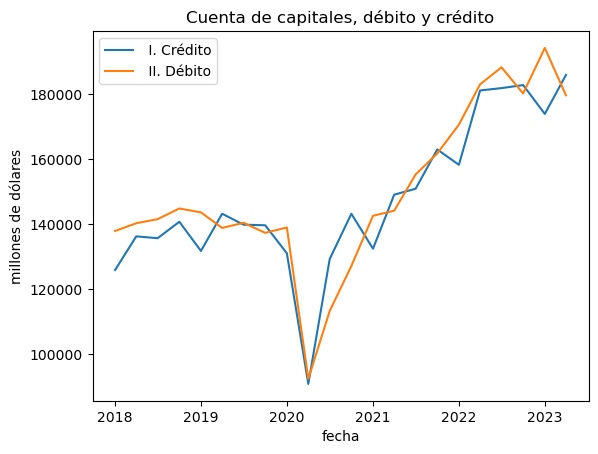

In [308]:
titulo3=[i.split('(I - II)', 1)[1] for i in cap.keys()]

x0=pd.to_datetime(list(corr.index),format="%d/%m/%Y")
y30=cap.iloc[:,1]
y31=cap.iloc[:,2]
plt.plot(x0,y14,x0,y22)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta de capitales, débito y crédito')
plt.legend([titulo3[1],titulo3[2]])

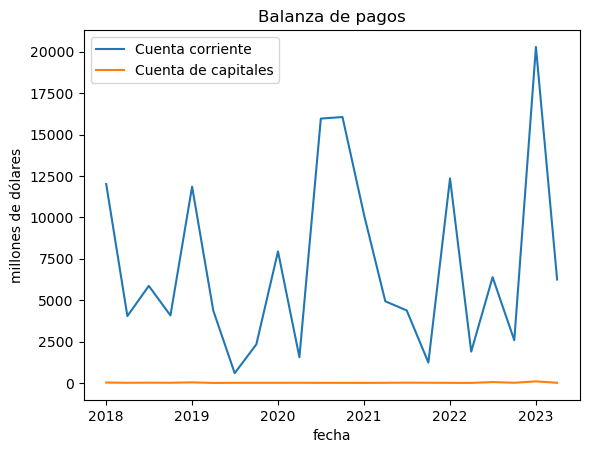

In [279]:
x0=pd.to_datetime(list(corr.index),format="%d/%m/%Y")
y00=corr.iloc[:,0]
y01=cap.iloc[:,0]

plt.plot(x0,y00,x0,y01)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Balanza de pagos')
plt.legend(['Cuenta corriente','Cuenta de capitales'])

plt.show()

### Cuenta corriente. Crédito

Se observa que la cuenta de crédito de cuenta corriente más grande proviene de la cuenta de bienes, la cual comprenden exportaciones de mercancías y asciende a más de 175 mil millones de pesos. Por su parte, la segunda cuenta más grande (aunque considerablemente más chica que la cuenta de bienes) es la cuenta de ingresos secundarios, los cuales son casi su totalidad ingresos por remesas y ascienden a poco menos de 23 mil millones de pesos. 

Por su parte, la cuenta de servicios primarios de crédito comprende utilidades, dividendos, intereses y remuneración de empleados, y ascendió a poco menos de 23 mil millones de pesos. Por otro lado, las de servicios suman transporte, viajes, servicios empresariales, propiedad intelectual entre los más importantes. 

No obstante, en saldos netos (débito - crédito) la cuenta corriente de bienes, servicios e ingresos primarios se encuentra en saldos positivos, mientras que sólo la cuenta de ingresos secundarios se encuentra en saldos negativos. Por otro lado, se observa un poco de estacionalidad en las cuentas de ingresos primarios e ingresos secundarios.

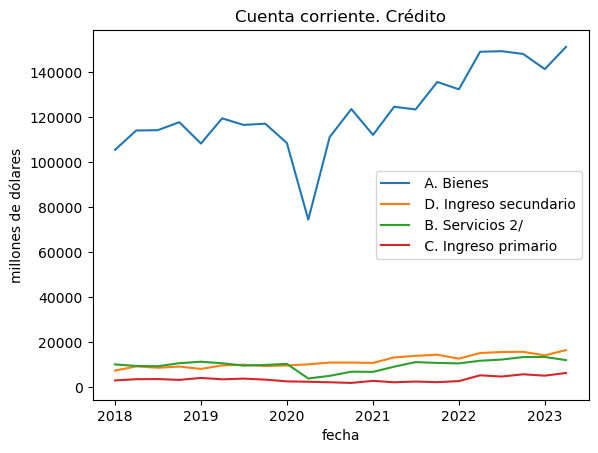

In [266]:
titulo1=[i.split('(A + B + C + D)', 1)[1] for i in c_corr_credito.keys()]

x1=pd.to_datetime(list(corr_credito.index),format="%d/%m/%Y")
y10=corr_credito.iloc[:,0]
y11=corr_credito.iloc[:,1]
y12=corr_credito.iloc[:,2]
y13=corr_credito.iloc[:,3]
y14=corr_credito.iloc[:,4]


plt.plot(x1,y10,x1,y11,x1,y12,x1,y13)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Crédito')
plt.legend([titulo1[0],titulo1[1],titulo1[2],titulo1[3]])

plt.show()

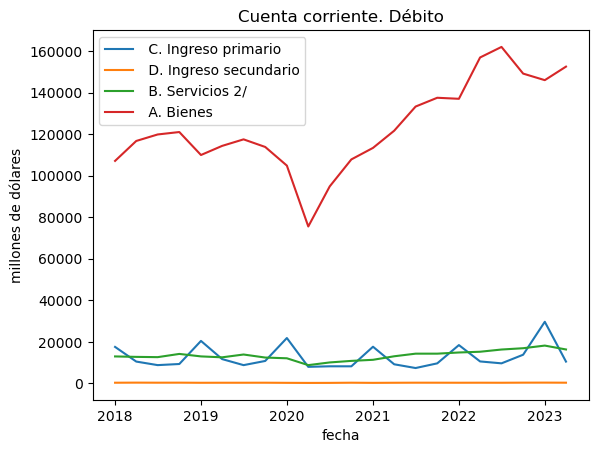

In [273]:

titulo2=[i.split('(A + B + C + D)', 1)[1] for i in corr_debito.keys()]

x2=pd.to_datetime(list(corr_debito.index),format="%d/%m/%Y")
y20=corr_debito.iloc[:,0]
y21=corr_debito.iloc[:,1]
y22=corr_debito.iloc[:,2]
y23=corr_debito.iloc[:,3]
y24=corr_debito.iloc[:,4]


plt.plot(x2,y21,x2,y20,x2,y23,x2,y24)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Débito')
plt.legend([titulo2[1],titulo2[0],titulo2[3],titulo2[4]])

plt.show()

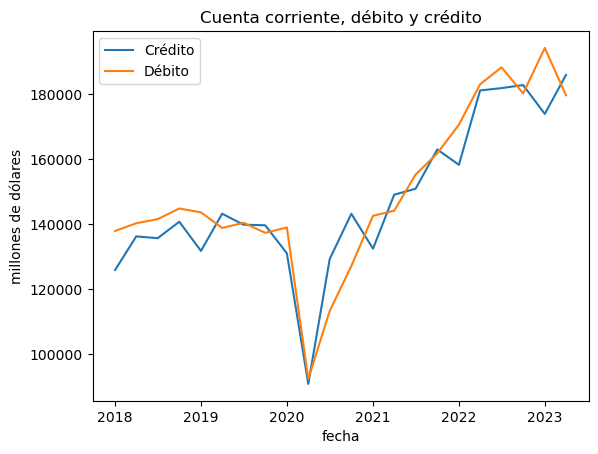

In [310]:

x0=pd.to_datetime(list(corr.index),format="%d/%m/%Y")
plt.plot(x0,y14,x0,y22)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente, débito y crédito')
plt.legend(['Crédito','Débito'])

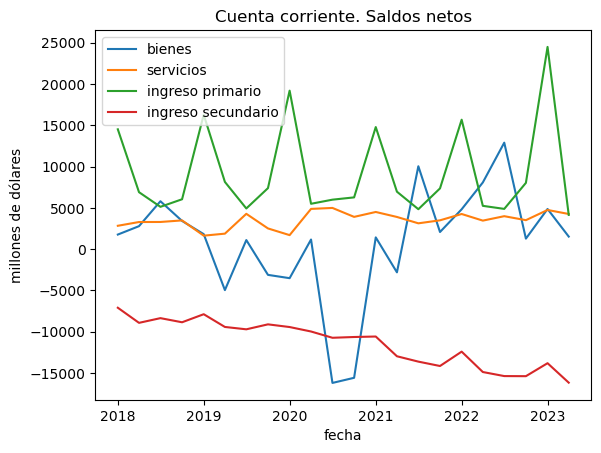

In [295]:
corr_neto_bienes=corr_debito.iloc[:,4]-corr_credito.iloc[:,0]
corr_neto_serv=corr_debito.iloc[:,3]-corr_credito.iloc[:,2]
corr_neto_ingprim=corr_debito.iloc[:,1]-corr_credito.iloc[:,3]
corr_neto_ingsec=corr_debito.iloc[:,0]-corr_credito.iloc[:,1]
plt.plot(x2,corr_neto_bienes,x2,corr_neto_serv,x2,corr_neto_ingprim,x2,corr_neto_ingsec)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Saldos netos')
plt.legend(['bienes','servicios','ingreso primario','ingreso secundario'])


### Cuenta corriente. Débito

### 2. Selección de variables explicativas

Dado que en la cuenta de crédito los bienes fueron la subcuenta más grande con 178 mil millones de dólares, se revisó el análisis de exportaciones e importaciones del [atlas de Harvard](https://atlas.cid.harvard.edu/countries/138/export-basket) para México. De acuerdo con dicha base de datos, las principales *exportaciones netas* para México en 2021 fueron en autos y autopartes (~28%), computadoras (~14%), petróleo (~8.3%), otros minerales (~8.5%), así como alimentos, bebidas y agropecuarios (~8%), entre otros. Por ello, se incluyó en el modelo la producción industrial de estos componentes.

Por otro lado, las cuentas de ingresos secundarios  también incluyen los ingresos por remesas, así como para la cuenta de servicios se incluyeron turismo, propiedad intelectual, que son los principales componentes.

Por todo lo anterior, se incluyeron en el modelo las siguientes variables:

* IGAE base 2018, actividades primarias, serie original, mensual, publicada por INEGI.
* Índice de producción industrial minera, mensual, publicada por INEGI.
* Índice de producción de industria alimentaria, mensual, publicada por INEGI.
* Índice de producción de industria de las bebidas y del tabaco, mensual, publicada por INEGI.
* Índice de pabricación de productos derivados del petróleo y del carbón, mensual, publicada por INEGI.
* Índice de pabricación de maquinaria y equipo, mensual, publicada por INEGI.
* Índice de pabricación de equipo de computación, comunicación, medición y de otros equipos, componentes y accesorios electrónicos, mensual, publicada por INEGI.
* Venta al mayoreo de vehículos al exterior en unidades, mensual, publicada por INEGI.
* Ingresos por remesas en millones de dólares, mensual, publicada por Banco de México.
* Tipo de cambio peso-dólar promedio FIX mensual, publicada por banco de México.
* Indice de volumen de la inversión fija bruta, Maquinaria y equipo total 
* Indice de volumen de la inversión fija bruta, Construcción 

Destacan las siguientes características:

1. Debido a que algunas variables están en dólares y otras en pesos, se usa como control el tipo de cambio FIX promedio del periodo
2. Se decidió descargar las series originales para aplicar luego su propio proceso de desestacionalización
3. Dado que las series de balanza de pagos son trimestrales y las variables explicativas son mensuales, se realizó un nowcasting de las series de balanza de pagos

In [370]:
def descarga_cc(serie):
    return descargar_banxico(serie,'2018-01-01','2023-06-01')
agropec=descargar_banxico('SR17695','2018-01-01','2023-06-01')
mineria=descargar_banxico('SR17532','2018-01-01','2023-06-01')
aliment=descargar_banxico('SR17546','2018-01-01','2023-06-01')
bebtab=descargar_banxico('SR17547','2018-01-01','2023-06-01')
petrol=descargar_banxico('SR17555','2018-01-01','2023-06-01')
maquina=descargar_banxico('SR17561','2018-01-01','2023-06-01')
automot=descargar_banxico('SR17564','2018-01-01','2023-06-01')
computo=descargar_banxico('SR17562','2018-01-01','2023-06-01')
remesas=descargar_banxico('SE27803','2018-01-01','2023-06-01')
usdmxn=descargar_banxico('SF17908','2018-01-01','2023-06-01')


In [395]:
def seas_adj(serie):
    str1=sm.tsa.seasonal_decompose(serie,period=4,model="multiplicative")
    return str1.trend

pd.concat([mineria,aliment,bebtab,petrol,maquina,automot,computo,remesas,usdmxn],axis=1).apply(lambda x:seas_adj(x))

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [394]:
mineria

'Índice de volumen de la producción industrial Series originales Minería'

### 3. Explicación de modelos autoarima, redes neuronales, crossval, inferencia bayesiana (quizá gridsearch)
Justificar selección de parámetros 

In [358]:
import statsmodels.api as sm

result = sm.tsa.seasonal_decompose(corr,period=4, model="multiplicative")
corr_sa=result.trend


,seasonal,trend,resid,0,Cuenta corriente (I - II)
fecha,,,,,
01/01/2018,1.843346,NaN,NaN,12013.139308,12013.139308
01/04/2018,0.555097,NaN,NaN,4038.476167,4038.476167
01/07/2018,0.909892,6477.273036,0.994449,5860.898059,5860.898059
01/10/2018,0.691666,6498.703057,0.907174,4077.688449,4077.688449
01/01/2019,1.843346,5881.775380,1.093042,11850.919632,11850.919632
01/04/2019,0.555097,5004.797654,1.573761,4372.136008,4372.136008
01/07/2019,0.909892,4297.778219,0.151340,591.816800,591.816800
01/10/2019,0.691666,3457.052958,0.974832,2330.947906,2330.947906
01/01/2020,1.843346,5026.346962,0.857124,7941.504692,7941.504692


### 4. Modelos de predicción para cuenta corriente considerados

#### 4.1. Modelo autoarima

#### 4.2. Modelo de redes neuronales

#### 4.3. Modelo de inferencia bayesiana

### 5. Conclusiones